In [2]:
import sys
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('../tracr/')
sys.path.append('..')
import os
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')


device = t.device("cuda" if t.cuda.is_available() else "CPU")
print(device)

cuda


In [4]:
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained(
    'gpt2-small',
    center_writing_weights=False,
    center_unembed=False,
    fold_ln=False,
    device=device,
)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)
model.set_use_attn_result(True)


with open(f'acdcpp_edges_acdcpp_scores.json', 'r') as f:
    acdcpp_scores = json.load(f)
    
#all_edges = parse_relevant_edges(exp)
acdcpp_scores = acdcpp_scores['-10']
all_edges = set(acdcpp_scores.keys())
from acdc.docstring.utils import get_docstring_subgraph_true_edges

true_edges_tuples = get_docstring_subgraph_true_edges()
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]').replace('None', ':')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{child_name}{replace_parens(child_idx)}{parent_name}{replace_parens(parent_idx)}')

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [9]:
true_edges - all_edges

set()

In [5]:
with open('../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-docstring-docstring_metric-False-0.json', 'r') as f:
    orig_perf = json.load(f)

# Attribution Scores Scatter Plot

In [ ]:
acdc_attrs = []
acdcpp_attrs = []
is_in_circuit = []

for acdc_attr_key in acdc_scores[list(acdc_scores.keys())[0]]:
    acdcpp_attr = acdcpp_scores.get(acdc_attr_key, None)
    if acdcpp_attr:
        acdc_attrs.append(acdc_scores[list(acdc_scores.keys())[0]][acdc_attr_key])
        acdcpp_attrs.append(acdcpp_attr)
        if acdc_attr_key in true_edges:
            is_in_circuit.append(True)
        else:
            is_in_circuit.append(False)

scatter_df = pd.DataFrame({'acdc_attrs': acdc_attrs, 'acdcpp_attrs': acdcpp_attrs, 'is_in_circuit': is_in_circuit})

ax = plt.gca()
ax.scatter(
    scatter_df[scatter_df['is_in_circuit'] == True]['acdc_attrs'],
    scatter_df[scatter_df['is_in_circuit'] == True]['acdcpp_attrs'],
    marker='o', s=5,c='#ff7f0e', label='Edge in circuit'
)
ax.scatter(
    scatter_df[scatter_df['is_in_circuit'] == False]['acdc_attrs'],
    scatter_df[scatter_df['is_in_circuit'] == False]['acdcpp_attrs'],
    marker='o', s=5,c='#1f77b4', label='Edge not in circuit'
)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, linestyle='dashed', label='y = x')
ax.set_xlabel('ACDC Edge Score')
ax.set_ylabel('ACDC++ Edge Score')
ax.set_title('ACDC++ vs ACDC Edge Attribution Scores (Docstring Circuit)')
ax.legend()
plt.savefig('ACDC++_vs_ACDC_Scores_Docstring.png')

In [27]:
mpl.rcParams["axes.prop_cycle"]

'#1f77b4'
'#ff7f0e'
'#2ca02c'
'#d62728'
'#9467bd'
'#8c564b'
'#e377c2'
'#7f7f7f'
'#bcbd22'
'#17becf'


# ROC Curve

In [28]:
print(np.quantile(acdc_attrs, [0, .1, .25, .5, 0.75, .9, 1]))
print(np.quantile(acdcpp_attrs, [0, .1, .25, .5, 0.75, .9, 1]))

[2.98023224e-07 2.87467241e-04 1.21507049e-03 4.65348363e-03
 1.72266215e-02 7.10947990e-02 1.42714685e+00]
[4.10713255e-07 2.24406437e-04 1.17274639e-03 4.93619125e-03
 1.97799378e-02 7.21177876e-02 4.55413342e+00]


In [13]:
def edges_after_acdcpp(thresh):
    edges = set()
    for edge, attr in acdcpp_scores.items():
        # If attr < thresh, would've been removed
        if abs(attr) >= thresh:
            edges.add(edge)
    return edges

data = {
    'Threshold': [0],
    'ACDCpp TPR': [1],
    'ACDCpp TNR': [0],
    'ACDCpp FPR': [1],
    'ACDCpp FNR': [0],
#     'TPR': [1],
#     'TNR': [0],
#     'FPR': [1],
#     'FNR': [0],
}

for thresh in np.logspace(-3, 1, num=50, base=5):
    data['Threshold'].append(float(thresh))
    # Variables prefixed with pp_ are after ADCDCpp only
    pp_edges = edges_after_acdcpp(float(thresh))
    #edges = set(acdc_scores[thresh].keys())
    
    pp_tp = len(pp_edges.intersection(true_edges))
    pp_tn = len((all_edges - true_edges).intersection(all_edges - pp_edges))
    pp_fp = len(pp_edges - true_edges)
    pp_fn = len(true_edges - pp_edges)

#     tp = len(edges.intersection(true_edges))
#     tn = len((all_edges - true_edges).intersection(all_edges - edges))
#     fp = len(edges - true_edges)
#     fn = len(true_edges - edges)

    pp_tpr = pp_tp / (pp_tp + pp_fn)
    pp_tnr = pp_tn / (pp_tn + pp_fp)
    pp_fpr = 1 - pp_tnr
    pp_fnr = 1 - pp_tpr

#     tpr = tp / (tp + fn)
#     tnr = tn / (tn + fp)
#     fpr = 1 - tnr
#     fnr = 1 - tpr

    data['ACDCpp TPR'].append(pp_tpr)
    data['ACDCpp TNR'].append(pp_tnr)
    data['ACDCpp FPR'].append(pp_fpr)
    data['ACDCpp FNR'].append(pp_fnr)

#     data['TPR'].append(tpr)
#     data['TNR'].append(tnr)
#     data['FPR'].append(fpr)
#     data['FNR'].append(fnr)

df = pd.DataFrame(data)
# Add thresh inf to end of df
row = [np.inf, 0, 1, 0, 1]# 0, 1, 0, 1]
df.loc[len(df)] = row

In [14]:
df

,Threshold,ACDCpp TPR,ACDCpp TNR,ACDCpp FPR,ACDCpp FNR
0,0.000000,1.000000,0.000000,1.000000,0.000000
1,0.008000,1.000000,0.568245,0.431755,0.000000
2,0.009123,1.000000,0.587744,0.412256,0.000000
3,0.010404,1.000000,0.609331,0.390669,0.000000
4,0.011865,1.000000,0.633705,0.366295,0.000000
5,0.013531,1.000000,0.658774,0.341226,0.000000
6,0.015431,1.000000,0.676184,0.323816,0.000000
7,0.017597,1.000000,0.697075,0.302925,0.000000
8,0.020068,1.000000,0.722841,0.277159,0.000000
9,0.022885,1.000000,0.743036,0.256964,0.000000


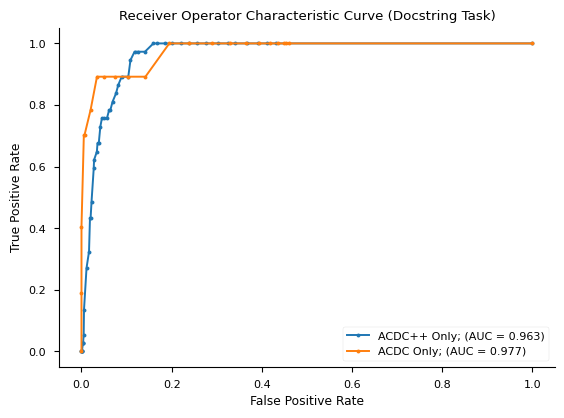

In [15]:
# Calculate AUC using trapezoidal rule
from sklearn.metrics import auc

from scipy import integrate

acdcpp_auc = round(abs(auc(df['ACDCpp FPR'], df['ACDCpp TPR'])), 3)
acdc_auc = round(
    abs(
        auc(
            orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_fpr'],
            orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_tpr']
        )
    ), 3)

plt.plot(df['ACDCpp FPR'], df['ACDCpp TPR'], marker='.', label=f'ACDC++ Only; (AUC = {acdcpp_auc})')
plt.plot(
    orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_fpr'],
    orig_perf['trained']['random_ablation']['docstring']['docstring_metric']['ACDC']['edge_tpr'],
    marker='.', 
    label=f'ACDC Only; (AUC = {acdc_auc})'
)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Curve (Docstring Task)')
plt.legend()
plt.savefig('ROC_Curve.png')

In [91]:
df['pp_Youdens_J'] = df['ACDCpp TPR'] - df['ACDCpp FPR']
df['Youdens_J'] = df['TPR'] - df['FPR']
best_threshold_pp = df.loc[df['pp_Youdens_J'].idxmax(), 'Threshold']
best_threshold = df.loc[df['Youdens_J'].idxmax(), 'Threshold']
print(best_threshold_pp, best_threshold)

0.0473844 0.1688318


In [16]:
scores_data = {'attr': [], 'is_in_circuit': []}
for edge, attr in acdcpp_scores.items():
    scores_data['attr'].append(attr)
    if edge in true_edges:
        scores_data['is_in_circuit'].append(True)
    else:
        scores_data['is_in_circuit'].append(False)
        
scores_df = pd.DataFrame(scores_data)

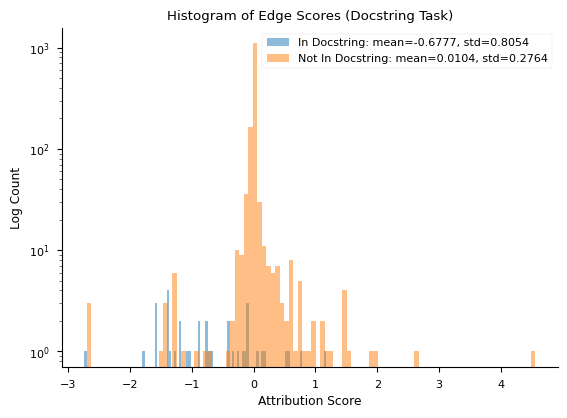

In [18]:
# Calculate the mean and standard deviation of scores for positive and negative cases
positive_scores = scores_df[scores_df['is_in_circuit'] == True]['attr']
negative_scores = scores_df[scores_df['is_in_circuit'] == False]['attr']

positive_mean = np.mean(positive_scores)
positive_std = np.std(positive_scores)

negative_mean = np.mean(negative_scores)
negative_std = np.std(negative_scores)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the distribution of scores for positive and negative cases
ax.hist(positive_scores, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'In Docstring: mean={positive_mean:.4f}, std={positive_std:.4f}')
ax.hist(negative_scores, 
        bins=100, 
        alpha=0.5, 
        log=True,
        label=f'Not In Docstring: mean={negative_mean:.4f}, std={negative_std:.4f}')

# Set the title and labels
ax.set_title('Histogram of Edge Scores (Docstring Task)')
ax.set_xlabel('Attribution Score')
ax.set_ylabel('Log Count')

# Add a legend
ax.legend(loc='upper right')

# Show the plot
plt.show()
fig.savefig('Hist_Scores.png')